In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
%matplotlib inline
from IPython.display import display, clear_output, set_matplotlib_formats

In [5]:
class Deer():
    def __init__(self,x=None,y=None,infection = False,U=0,gender='Male'):
        '''Initialize a deer at a random location on the board
           Parameters
           ===================================================
           x - x position in the world
           y - y position in the world
           infection - T/F if the deer has the piron
           sickCount - How long has the deer had the piron
           gender - What gender is the deer
        '''
        self.x = x 
        self.y = y
        if x == None:
            self.x = 0
        if y == None:
            self.y = 0
        self.infected = infection
        self.sick_count = 0
        self.gender = gender
        self.alive = True
    def draw(self):
        '''This function will draw deer as circles on a 2D grid. A green circle is a susceptible deer,
           while a red one is infected.
           '''
        if self.infected == True:
            color = 'r'
        else:
            color = 'g'
        plt.scatter(self.x,self.y,c=color,s=20)
    def age(self):
        '''
        THis function ages the deer. If they are infected, it increments the months that deer has been sick. If
        the deer have been infected for 36 months, it will set the deer to dead.
        '''
        if self.infected:
            self.sick_count += 1
        if self.sick_count >= 36:
            self.alive = False

In [6]:
class World():
    def __init__(self,x_size,y_size,terrain = '',infected_male_deer = 0,infected_female_deer = 0,male_deer = 0,female_deer = 0):
        '''
        Initializes a world for the deer to exist on.
        Parameters
        ============================================
        x_size - The x dimension of the world
        y_size = The y dimension of the world
        terrain - two dimensional grid of environment potential
        infected_male_deer - initial number of infected male deer
        infected_female_deer - initial number of infected female deer
        male_deer - initial number of susceptible male deer
        female_deer - initial number of susceptible female deer
        deer_locations - Heat map of deer locations in the world
        '''
        self.x_size = x_size
        self.y_size = y_size
        self.poop_map = np.zeros((self.y_size,self.x_size))
        self.deer_list = []
        for m in range(male_deer):
            self.deer_list.append(Deer(x=np.random.randint(0,x_size),y=np.random.randint(0,y_size),gender='Male'))
        for f in range(female_deer):
            self.deer_list.append(Deer(x=np.random.randint(0,x_size),y=np.random.randint(0,y_size),gender='Female'))
        for m in range(infected_male_deer):
            self.deer_list.append(Deer(x=np.random.randint(0,x_size),y=np.random.randint(0,y_size),gender='Male',infection = True))
        for f in range(infected_female_deer):
            self.deer_list.append(Deer(x=np.random.randint(0,x_size),y=np.random.randint(0,y_size),gender='Female',infection = True))
        self.terrain = terrain
        self.deer_locations = np.zeros_like(self.terrain)
        for d in self.deer_list:
            self.deer_locations[int(d.y),int(d.x)] += 1
    def draw_poop(self,cmap = 'copper'):
        '''
        This function will draw the map showing prion locations and levels.
        Parameters
        ==================================================================
        cmap - color map for prion levels
        '''
        plt.imshow(self.poop_map,cmap=cmap)
        plt.pcolormesh(self.poop_map, vmin=0, vmax=1,cmap=cmap)
        plt.colorbar()
        
    def draw_potential(self,cmap='viridis'):
        '''
        This function will draw the map showing the potential deer are subject to.
        Parameters
        ==================================================================
        cmap - color map for potential
        '''
        plt.imshow(self.terrain,cmap=cmap)
        plt.colorbar()
        
    def draw_deer(self):
        '''
        This function will draw the deer that the exist in the simulation. Deer that are infected
        will be drawn in green, and deer that are infected will be drawn in red.
        '''
        for d in self.deer_list:
            d.draw()
        plt.xlim(0,self.x_size-1)
        plt.ylim(0,self.y_size-1)
    def move_deer(self):
        '''
        This function moves the deer in the world.
        '''
        for d in self.deer_list:
            h = 1
            gamma = 1
            if d.gender == 'Female':
                C = .75
            if d.gender == 'Male':
                Amp = .05
                C = .75 + Amp*(np.cos(2*np.pi/12)+1)/2
                
            temp_x = int(d.x)
            temp_y = int(d.y)
            
            if d.x < self.x_size-1 and d.x > 0:
                d.x += -h/gamma * (self.terrain[temp_y,temp_x+1]-self.terrain[temp_y,temp_x-1])/2 + np.sqrt(h)/gamma*C*np.random.normal(0,1)
                
            if int(d.x) == 0:
                d.x += np.sqrt(h)/gamma*C*np.random.normal(0,1)
            if int(d.x) == self.x_size - 1:
                d.x += np.sqrt(h)/gamma*C*np.random.normal(0,1)
                
            if d.x < 0:
                d.x = 0
            if d.x >= self.x_size:
                d.x = self.x_size - 1
            
            if d.y < self.y_size-1 and d.y > 0:
                d.y += -h/gamma * (self.terrain[temp_y+1,temp_x]-self.terrain[temp_y-1,temp_y])/2 + np.sqrt(h)/gamma*C*np.random.normal(0,1)
            if int(d.y) == 0:
                d.y += np.sqrt(h)/gamma*C*np.random.normal(0,1)
            if int(d.y) == self.y_size - 1:
                d.y += np.sqrt(h)/gamma*C*np.random.normal(0,1)

            if d.y < 0:
                d.y = 0 
            if d.y >= self.y_size:
                d.y = self.y_size - 1
                
        self.deer_locations = np.zeros_like(self.terrain)
        for d in self.deer_list:
            self.deer_locations[int(d.y),int(d.x)] += 1
    def poop(self):
        '''
        This function allows the deer to interact with the environment and leave prions behind
        '''
        for d in self.deer_list:
            if d.infected == True and d.sick_count > 3:
                self.poop_map[int(d.y),int(d.x)] += .01
    def infect_deer(self):
        '''
        This function allows the deer to interact with the environment and pick up prions
        '''
        for d in self.deer_list:
            if d.infected == False:
                if np.random.uniform() < self.poop_map[int(d.y),int(d.x)]:
                    d.infected = True
    def kill_deer(self):
        '''
        This function checks to see if deer are alive, and removes the dead ones from the world
        '''
        for d in self.deer_list:
            if not d.alive:
                self.deer_list.remove(d)
    def age_deer(self):
        '''
        This function incriments the deers age and sick counter by one.
        '''
        for d in self.deer_list:
            d.age()
            
    def run_trial(self,steps,map_type='poop',cmap='copper'):
        '''
        Run a simulation for a number of timesteps
        Parameters
        ==========================================
        steps - Number of time steps to run the simulation
        map_type - Which map do you want to display
        cmap - The colormap for the display map
        '''
        for t in range(steps):
            self.move_deer()
            self.infect_deer()
            self.poop()
            self.age_deer()
            self.kill_deer()
            
        if map_type == 'poop':
            self.draw_poop(cmap)
        elif map_type == 'terrain':
            self.draw_potential(cmap)
        elif map_type == None:
            pass
        else:
            raise RuntimeError('No map of type: '+ map_type)
        self.draw_deer()

In [145]:
t = np.zeros((50,50))
for x in range(t.shape[0]):
    for y in range(t.shape[1]):
#         t[x,y] = -1*np.exp(-1/500*(x-25)**2-1/50*(y-25)**2) - np.exp(-1/15*(x-2)**2-1/15*(y-5)**2) - np.exp(-1/5*(x-5)**2-1/5*(y-30)**2) - np.exp(-1/23*(x-40)**2-1/23*(y-40)**2)- np.exp(-1/20*(x-40)**2-1/20*(y-10)**2)
        t[x,y] = -(x**2+y**2)/(50**2+50**2)

In [146]:
trial = World(50,50,terrain=t,male_deer=100,female_deer=100,infected_male_deer=1)

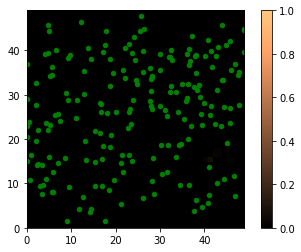

In [150]:
trial.run_trial(50,map_type='poop')

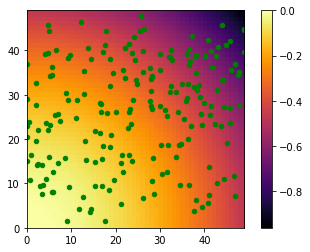

In [151]:
trial.draw_potential('inferno')
trial.draw_deer()

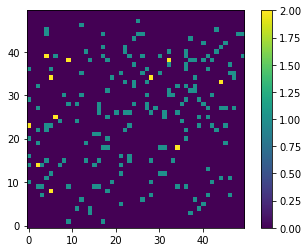

In [152]:
plt.imshow(trial.deer_locations,origin='lower')
plt.colorbar()